In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Checking files data files
import os
print(os.listdir("ecommerce-dataset"))

['category_tree.csv', 'events.csv', 'item_properties_part1.csv', 'item_properties_part2.csv']


In [6]:
## loading items dataset
items = pd.read_csv("ecommerce-dataset/item_properties_part1.csv")
items = items[:10999]
items.tail(10)

,timestamp,itemid,property,value
10989,1439089200000,183697,888,231316 237874 610517 n108.000 424566 784581 12...
10990,1441508400000,337184,978,684814 234274
10991,1433646000000,55909,888,1072784
10992,1431226800000,209920,764,1285872
10993,1432436400000,257606,888,1280825
10994,1431226800000,329250,available,0
10995,1440298800000,387609,available,1
10996,1437274800000,94406,790,n306720.000
10997,1431226800000,337872,categoryid,1113
10998,1435460400000,334542,451,1141052 n36.000


In [7]:
items.shape

(10999, 4)

In [8]:
import datetime
dtime = []
for i in items['timestamp']:
    dtime.append(datetime.datetime.fromtimestamp(i//1000))

In [9]:
items['timestamp'] = dtime

In [10]:
items.head(10)

,timestamp,itemid,property,value
0,2015-06-28 08:30:00,460429,categoryid,1338
1,2015-09-06 08:30:00,206783,888,1116713 960601 n277.200
2,2015-08-09 08:30:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 08:30:00,59481,790,n15360.000
4,2015-05-17 08:30:00,156781,917,828513
5,2015-07-05 08:30:00,285026,available,0
6,2015-06-14 08:30:00,89534,213,1121373
7,2015-05-17 08:30:00,264312,6,319724
8,2015-06-07 08:30:00,229370,202,1330310
9,2015-06-14 08:30:00,98113,451,1141052 n48.000


In [30]:
## Loading user-interactions, i.e, events dataset
events = pd.read_csv("ecommerce-dataset/events.csv")
events = events[:27561]
events.head(10)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
5,1433224086234,972639,view,22556,NaN
6,1433221923240,810725,view,443030,NaN
7,1433223291897,794181,view,439202,NaN
8,1433220899221,824915,view,428805,NaN
9,1433221204592,339335,view,82389,NaN


(27561, 5)
view           26700
addtocart        639
transaction      222
Name: event, dtype: int64


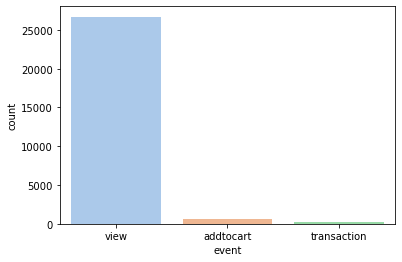

In [3]:
print(events.shape)
print(events['event'].value_counts())
sns.countplot(x='event', data=events, palette='pastel')

## TODO: load and analyse Category datasets

In [13]:
## Finding Unique visiters i.e, all the customers
customers = events['visitorid'].unique()

print("All visitors:", events['visitorid'].size)
print("All customers:", customers.size)

All visitors: 27561
All customers: 16684


In [14]:
## Finding customers who purchased
customers_purchased = events[events.transactionid.notnull()].visitorid.unique()
print("Customers who bought something:",customers_purchased.size)

Customers who bought something: 136


event
addtocart      [5206, 10572, 255275, 356475, 312728, 63312, 1...
transaction    [356475, 15335, 81345, 150318, 310791, 54058, ...
view           [355908, 248676, 318965, 253185, 367447, 22556...
Name: itemid, dtype: object


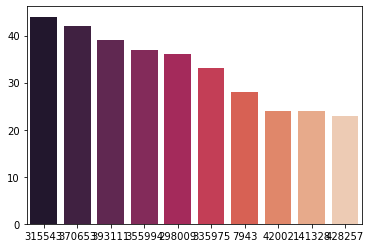

In [15]:
## grouping itemid with it's event type into a lost
grouped = events.groupby('event')['itemid'].apply(list)
print(grouped)

## Finding the most viewed items
import operator
views = grouped['view']
count_view = {}
views = np.array(views[:])

#counting unique value of itemids and respective views and conveting it to dictionary
unique, counts = np.unique(views, return_counts=True)
count_view = dict(zip(unique, counts))
sorted_view = sorted(count_view.items(), key= operator.itemgetter(1), reverse=True)

## intialising graph
x = [i[0] for i in sorted_view[:10]]
y = [i[1] for i in sorted_view[:10]]
sns.barplot(x, y, order=x, palette='rocket')

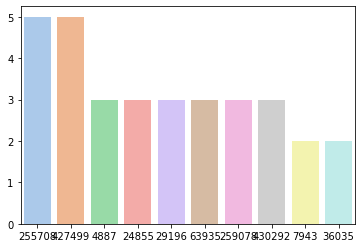

In [16]:
## Finding the most added to cart items
addtocart = grouped['addtocart']
count_cart = {}
addtocart = np.array(addtocart[:])

#counting unique value of itemids and respective addtocart and conveting it to dictionary
unique, counts = np.unique(addtocart, return_counts=True)
count_cart = dict(zip(unique, counts))
sorted_cart = sorted(count_cart.items(), key= operator.itemgetter(1), reverse=True)

## intialising graph
x = [i[0] for i in sorted_cart[:10]]
y = [i[1] for i in sorted_cart[:10]]
sns.barplot(x, y, order=x, palette='pastel')

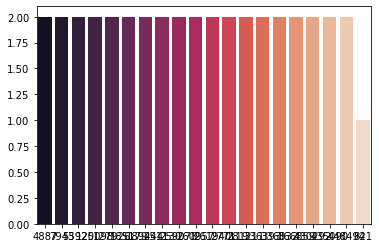

In [17]:
## Finding the most purchased items
transaction = grouped['transaction']
count_transaction = {}
transaction = np.array(transaction[:])

#counting unique value of itemids and respective addtocart and conveting it to dictionary
unique, counts = np.unique(transaction, return_counts=True)
count_transaction = dict(zip(unique, counts))
sorted_transaction = sorted(count_transaction.items(), key= operator.itemgetter(1), reverse=True)

## intialising graph
x = [i[0] for i in sorted_transaction[:20]]
y = [i[1] for i in sorted_transaction[:20]]
sns.barplot(x, y, order=x, palette='rocket')

# TODO: Modeling with lightfm

In [31]:
from sklearn import preprocessing
from lightfm import LightFM
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from sklearn.metrics import roc_auc_score
from lightfm.evaluation import auc_score
import time
import pickle
import datetime

In [32]:
# Sorting wrt date(dataset did not had index field as timestamp)
events = events.assign(date=pd.Series(datetime.datetime.fromtimestamp(i//1000).date() for i in events.timestamp))
events = events.sort_values('date').reset_index(drop=True)
events = events[['visitorid', 'itemid', 'event', 'date']]
events.tail(10)

,visitorid,itemid,event,date
27551,353455,114070,view,2015-06-03
27552,977950,197816,view,2015-06-03
27553,160659,443590,view,2015-06-03
27554,77390,258810,view,2015-06-03
27555,571645,36906,view,2015-06-03
27556,411496,192491,view,2015-06-03
27557,1004112,376137,view,2015-06-03
27558,382778,372293,view,2015-06-03
27559,913611,263437,view,2015-06-03
27560,838727,361963,view,2015-06-03


In [33]:
# Selecting interval
start_date = '2015-06-01'
end_date = '2015-06-03'
fd = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date()
events = events[(events.date >= fd(start_date)) & (events.date <= fd(end_date))]
    

In [34]:
# Splitting train and test data
split_point = np.int(np.round(events.shape[0]*0.8))
events_train = events.iloc[0:split_point]
events_test = events.iloc[split_point::]
# events_test = events_test[(events_test['visitorid'].isin(events_train['visitorid'])) & (events_test['itemid'].isin(events_train['itemid']))]


In [36]:
# Encoding the data and using visitorid and itemid as the only fields
id_cols = ['visitorid','itemid']
trans_cat_train = {}
trans_cat_test = {}

for k in id_cols:
    cate_enc = preprocessing.LabelEncoder()
    trans_cat_train[k] = cate_enc.fit_transform(events_train[k].values)
    trans_cat_test[k] = cate_enc.transform(events_test[k].values)

ValueError: y contains previously unseen labels: [17, 52, 202, 283, 1289, 2360, 2681, 2715, 3023, 3473, 3926, 3952, 4816, 5334, 5967, 6195, 7600, 7969, 8683, 9230, 9385, 9487, 9520, 9820, 10481, 10583, 10697, 11199, 11243, 11906, 12988, 14259, 15463, 15866, 15967, 15985, 17128, 17380, 17579, 17948, 18767, 18990, 19297, 20434, 20892, 21302, 22804, 22893, 22897, 23005, 23430, 24192, 24242, 24696, 26007, 26989, 27325, 27370, 28834, 29007, 29150, 29357, 30557, 30900, 31036, 31251, 34410, 34976, 35368, 35657, 35847, 36471, 37282, 37705, 37743, 37860, 38692, 39210, 39743, 40032, 40633, 40711, 42005, 42324, 43488, 43571, 44414, 44904, 45200, 45207, 45876, 46036, 46071, 46863, 47294, 47641, 47721, 47991, 48253, 48323, 49125, 49277, 51757, 52024, 52071, 53501, 54448, 54522, 54928, 57448, 57966, 58469, 58697, 60574, 61972, 63675, 63744, 64334, 64883, 66253, 66612, 68410, 68843, 69363, 69672, 69804, 70677, 71128, 71482, 71743, 71784, 72334, 73611, 73901, 74174, 74340, 74360, 74377, 74419, 74884, 74965, 75319, 75548, 75883, 77021, 78347, 78354, 78356, 78445, 79083, 79098, 79261, 79853, 79911, 80066, 80233, 80936, 81731, 82531, 82627, 82904, 83213, 83684, 84103, 84842, 85130, 85211, 85555, 85680, 85924, 86914, 87057, 87612, 88329, 88897, 89329, 89333, 89370, 89713, 89812, 90496, 91170, 91199, 91288, 91625, 92571, 92594, 93191, 93237, 93793, 94077, 94912, 95123, 95329, 95934, 95935, 95980, 96314, 96458, 96793, 96814, 98152, 99319, 99622, 100224, 100585, 100950, 100985, 101094, 101612, 101806, 101966, 102369, 102765, 103413, 103601, 104078, 104240, 104709, 105241, 105324, 105479, 105498, 105520, 105626, 105720, 107897, 108038, 108298, 109318, 109331, 110346, 110401, 110755, 110760, 110945, 111279, 113277, 114772, 115498, 115547, 116114, 116410, 116524, 116866, 117419, 117494, 117686, 117926, 118993, 120298, 121322, 122149, 122350, 123053, 123114, 123300, 123463, 123730, 124132, 125034, 125042, 125124, 125208, 125355, 126495, 127107, 127222, 127255, 128269, 128917, 129022, 129621, 129678, 129984, 130160, 130398, 131375, 132550, 132802, 133266, 133528, 133583, 133884, 134224, 134927, 135096, 135210, 135434, 136940, 137639, 137869, 138175, 138303, 138494, 138770, 138975, 139032, 139479, 140386, 140488, 141380, 141637, 141642, 142800, 143326, 144914, 144977, 145192, 145306, 145520, 145541, 146058, 146253, 146422, 146578, 147370, 147438, 147544, 148159, 148859, 149194, 149457, 150186, 150333, 150420, 150492, 150770, 150870, 151930, 152183, 152557, 152929, 153120, 153171, 153502, 154313, 154344, 154692, 155662, 155844, 155879, 156998, 157335, 157828, 158508, 158878, 159965, 160024, 160229, 160254, 160461, 160537, 160659, 160809, 161152, 161722, 161958, 162271, 163049, 164306, 164532, 165755, 166260, 166536, 166776, 166912, 168634, 168660, 168958, 169172, 169528, 169586, 169635, 169764, 169814, 170012, 170822, 170832, 170834, 171485, 171675, 171898, 172080, 172136, 172528, 172601, 172647, 172915, 173648, 174677, 175021, 175097, 175166, 176155, 176404, 176779, 177091, 178417, 178484, 179275, 179286, 179412, 179966, 180799, 181736, 182577, 182701, 183192, 183652, 183975, 184719, 184819, 184854, 185121, 185222, 185428, 185437, 185540, 185586, 186484, 186960, 188081, 188601, 190752, 190771, 191189, 193647, 194262, 194967, 195001, 195729, 195802, 195884, 196476, 196478, 196502, 196654, 196657, 197182, 197359, 197383, 197834, 198032, 198281, 200045, 200866, 201713, 201715, 201876, 202428, 202920, 203679, 204233, 204385, 204545, 204682, 204795, 205464, 205793, 206275, 206844, 207082, 207188, 207639, 207698, 208678, 209198, 209520, 209527, 210107, 211355, 211836, 212098, 212112, 212509, 212696, 212882, 213672, 213812, 214045, 214754, 214886, 215001, 215219, 215227, 215660, 215857, 216221, 216702, 217064, 218479, 219044, 219332, 219688, 219839, 220142, 220299, 221413, 221601, 221816, 221827, 221934, 222046, 222421, 222519, 223285, 223335, 224550, 224597, 225130, 225132, 225631, 226253, 226693, 227096, 227125, 227131, 227237, 227590, 227847, 227912, 228171, 228188, 228447, 228660, 229043, 229189, 229324, 229334, 229348, 229523, 229563, 230242, 230557, 231037, 231248, 231806, 231979, 231990, 232203, 232363, 232696, 233019, 233163, 233689, 234479, 235666, 235945, 236443, 237192, 237322, 237486, 237732, 238197, 238555, 240545, 241093, 241927, 242335, 242468, 242605, 242650, 242690, 242741, 243519, 243601, 243753, 243898, 244049, 245072, 246541, 246667, 246921, 247273, 247356, 247461, 247622, 248091, 248199, 248474, 248628, 248754, 248970, 249655, 250601, 250690, 251547, 251789, 252349, 252571, 252614, 253267, 253410, 253433, 253740, 254012, 254888, 255541, 255794, 256858, 257102, 257254, 257574, 257832, 258073, 258099, 258500, 259010, 259017, 259156, 259336, 259685, 260584, 261334, 262796, 262933, 263053, 263140, 263391, 263607, 263618, 263699, 263956, 266181, 266477, 266961, 267254, 267340, 267401, 267774, 268399, 268640, 269408, 269830, 270092, 270198, 270902, 271475, 271675, 271969, 272120, 272717, 273613, 274700, 274785, 274802, 275177, 275436, 276665, 276686, 277459, 277948, 278066, 278087, 278457, 278480, 278620, 279068, 279839, 280107, 280637, 282572, 282580, 283429, 284262, 284408, 285440, 286153, 286448, 288291, 288313, 288568, 289832, 290933, 291125, 292149, 293022, 293146, 293469, 293722, 294132, 294440, 295068, 295259, 295384, 295655, 296188, 296360, 296401, 297770, 297914, 298337, 298770, 298809, 300080, 300126, 300200, 300714, 300882, 300987, 301025, 301530, 301651, 302036, 302151, 302442, 302819, 302963, 303091, 303355, 303367, 303392, 303466, 304527, 304559, 304950, 305234, 305368, 305601, 306652, 307980, 308273, 308430, 308613, 308723, 309865, 310148, 310301, 311579, 311999, 312283, 312287, 313385, 313739, 314419, 315162, 315460, 315552, 316079, 316107, 317065, 317746, 318224, 318389, 318665, 319153, 319482, 319602, 319617, 320642, 320690, 321763, 321890, 321900, 321983, 322046, 322059, 322206, 322929, 323339, 324056, 324733, 324802, 325697, 326345, 326536, 326637, 327957, 327963, 328455, 328629, 328672, 328994, 329290, 329380, 329466, 329910, 330390, 331270, 331854, 332259, 332656, 333029, 333746, 334841, 334918, 335199, 335757, 335875, 337013, 337355, 337951, 337981, 338682, 338728, 339082, 339171, 339379, 339920, 340011, 340388, 340592, 340701, 341816, 342289, 342679, 343026, 343187, 344239, 344779, 345267, 345330, 345455, 345667, 346429, 347066, 347415, 347543, 347573, 348011, 348930, 351021, 351168, 351437, 351575, 352536, 352567, 352759, 352913, 352931, 353304, 353455, 353532, 353784, 354708, 355743, 356385, 356789, 357166, 357445, 357847, 357880, 357981, 359096, 359407, 359596, 360732, 360817, 361340, 361629, 362241, 362897, 363260, 363698, 364814, 364981, 365058, 365175, 365309, 365826, 365944, 366342, 366538, 366879, 366933, 367023, 367289, 368621, 368645, 369265, 370311, 371257, 371321, 371429, 371476, 371491, 371582, 372448, 372591, 373081, 373449, 373935, 374235, 374574, 375549, 376273, 376509, 376546, 377021, 378106, 379058, 379255, 379292, 380413, 380550, 380553, 380834, 381863, 382094, 382778, 382903, 383662, 384132, 384375, 385307, 385617, 385668, 385694, 386204, 386556, 387229, 387301, 389682, 389870, 390130, 391666, 391672, 392291, 392377, 393080, 393230, 393417, 395612, 395634, 396060, 396457, 396557, 396652, 396900, 396917, 396976, 397139, 397631, 397748, 397975, 398041, 398887, 398894, 399048, 399159, 399196, 399577, 400038, 400160, 400735, 401515, 402148, 402268, 402510, 402656, 403210, 403639, 404519, 405136, 405640, 406222, 406943, 407721, 407724, 407832, 408053, 408280, 408301, 408382, 408689, 408955, 409458, 409461, 409485, 410033, 410811, 411351, 411354, 411496, 412310, 412501, 412933, 413322, 413912, 414675, 414686, 415291, 415409, 417241, 417456, 418642, 419026, 419048, 419602, 419913, 420279, 421205, 421750, 422329, 422473, 423249, 423384, 423429, 423760, 424258, 424351, 424918, 424984, 426172, 426250, 426779, 428108, 428270, 428901, 429419, 431115, 431411, 431896, 432175, 433547, 433866, 434329, 434370, 434596, 434989, 435149, 435321, 436593, 436931, 437002, 437219, 437518, 437740, 439397, 439771, 440298, 440369, 440515, 440611, 441270, 441325, 441375, 441446, 441570, 441763, 444192, 444957, 446040, 446291, 446396, 447178, 447273, 448574, 448988, 450060, 450202, 450598, 450604, 451044, 451271, 451406, 452327, 453221, 453788, 453922, 453942, 454010, 454158, 455086, 455299, 455599, 456732, 458120, 458756, 460575, 461115, 462556, 462929, 463400, 463575, 464240, 464612, 464846, 465056, 465118, 465364, 465637, 465836, 466054, 466399, 466412, 466417, 466460, 466552, 467190, 467301, 467476, 467975, 468109, 468641, 468681, 468832, 469598, 469919, 470070, 470707, 470907, 470951, 470990, 472237, 472645, 472734, 472739, 472815, 473378, 473588, 474017, 474849, 475109, 475176, 475718, 476629, 476932, 477164, 477204, 477962, 478152, 478327, 478658, 478753, 478823, 479038, 480160, 481064, 481913, 482123, 482404, 482822, 482839, 482894, 483531, 483661, 484022, 484092, 485303, 485632, 485698, 485726, 487184, 488040, 488195, 488238, 488634, 489130, 489611, 490103, 490285, 491964, 492521, 492996, 493105, 493862, 494012, 494129, 494770, 496089, 496751, 497998, 498101, 498298, 499003, 499004, 499077, 499249, 500061, 500152, 500379, 500598, 501031, 501938, 502669, 503068, 503297, 503595, 504353, 505034, 505139, 505303, 505499, 505811, 505849, 505905, 506116, 506678, 507382, 507616, 507641, 507787, 508690, 510103, 510698, 511583, 512201, 512291, 512834, 513731, 513820, 513889, 514608, 515095, 515279, 515618, 516122, 516993, 517335, 517373, 517556, 517619, 517806, 518218, 518363, 519159, 519575, 520438, 520630, 520728, 521151, 521772, 522549, 522553, 522556, 523428, 523433, 523450, 523604, 523648, 523883, 524902, 525685, 525977, 526106, 526600, 527085, 527837, 529745, 529793, 529836, 530800, 530907, 531742, 532291, 532461, 532484, 532672, 532839, 532870, 533261, 533543, 534294, 534940, 535225, 537735, 538165, 538180, 538420, 538485, 538539, 539145, 539397, 539785, 540434, 540582, 540646, 540828, 540911, 541323, 541443, 542123, 542247, 542755, 543126, 543510, 543664, 544887, 545485, 545900, 546217, 546502, 546759, 547195, 547415, 548134, 548156, 548450, 548596, 548805, 549048, 549454, 549932, 550181, 550471, 550510, 551135, 551442, 551625, 551960, 552445, 552478, 552590, 552612, 552627, 552687, 552749, 552886, 553209, 553616, 553787, 554074, 554324, 554529, 554566, 555300, 555651, 556284, 556319, 556951, 557404, 557497, 557775, 557863, 559201, 559602, 560131, 560328, 560586, 560889, 563713, 563733, 563964, 565078, 565282, 565754, 566850, 568052, 568138, 568620, 568856, 569225, 569509, 569607, 569845, 570392, 570399, 571123, 571126, 571165, 571278, 571340, 571561, 571615, 571645, 571823, 572553, 572673, 573438, 573521, 573590, 573865, 574032, 574564, 576470, 576693, 577045, 577069, 577146, 577930, 577980, 579232, 579989, 580011, 580325, 580408, 580899, 582669, 583421, 584559, 584670, 585085, 586232, 586250, 586531, 586860, 587153, 587190, 587578, 588901, 590001, 591069, 591235, 591870, 593142, 593763, 595905, 596034, 596360, 596466, 597313, 597404, 597848, 598458, 598795, 599057, 599846, 600094, 600148, 600222, 601085, 601523, 601541, 601730, 601864, 601984, 602084, 602482, 602902, 603877, 603880, 603965, 604624, 604978, 605002, 605357, 605399, 606052, 607700, 608542, 609493, 609821, 612213, 612270, 612300, 613566, 613628, 614388, 614535, 614544, 615184, 615198, 615580, 615868, 616137, 616321, 616565, 617474, 617663, 618262, 619230, 619259, 619370, 619602, 619670, 620501, 620789, 621186, 621474, 621588, 621746, 621820, 622013, 622568, 622761, 622893, 623277, 623828, 624048, 624671, 625814, 626103, 626252, 626297, 626727, 626772, 627284, 627826, 627846, 628192, 628232, 628499, 628637, 628688, 628981, 629596, 629631, 629657, 629844, 631065, 631556, 631594, 632035, 633443, 633586, 634258, 634876, 634967, 635996, 636111, 636300, 636558, 636867, 636923, 637028, 637942, 637953, 638616, 639023, 639266, 639429, 640465, 640477, 640602, 641365, 642634, 642808, 642937, 642983, 643129, 643745, 643921, 644119, 644169, 644194, 644560, 644602, 644939, 645653, 645739, 646243, 646570, 646658, 646770, 647694, 647728, 648162, 648684, 649213, 649235, 649863, 649881, 649967, 650711, 650966, 651152, 651314, 651447, 651477, 651645, 651889, 651974, 652538, 652588, 652647, 653217, 653560, 653693, 653942, 654345, 654424, 654581, 655103, 655473, 655839, 656815, 657105, 657303, 657372, 657847, 658373, 658621, 658857, 659011, 659471, 659885, 660116, 660158, 661042, 661726, 661757, 662045, 662057, 662099, 662106, 662534, 662884, 663222, 663788, 663805, 664002, 664580, 664921, 664987, 665014, 665884, 666586, 666626, 667532, 668111, 668282, 669451, 669724, 669801, 670750, 670775, 671484, 671859, 672379, 672429, 672697, 673384, 673572, 673897, 674672, 675292, 676098, 676900, 677425, 678302, 679155, 679225, 680414, 680537, 680862, 681094, 681202, 684152, 684528, 685766, 686203, 686311, 686854, 687450, 687586, 687623, 687642, 688559, 688830, 689116, 689160, 690103, 690264, 690284, 690811, 691452, 692411, 692866, 693284, 694413, 694597, 694822, 695519, 695554, 695880, 696311, 697371, 697501, 697701, 697939, 698027, 698228, 699027, 699425, 699506, 699642, 700077, 700188, 700530, 700588, 700745, 700921, 701672, 701896, 701924, 702031, 702297, 702537, 702689, 704192, 704650, 705201, 705251, 705271, 705549, 705981, 706546, 707131, 707154, 707404, 707826, 708057, 708128, 708464, 708739, 709620, 709631, 709872, 710189, 710612, 712026, 712183, 712875, 713317, 713355, 714161, 714252, 714347, 714390, 715196, 715753, 716222, 716381, 716971, 717232, 717469, 717556, 718348, 718660, 718816, 718921, 720065, 720248, 720645, 720752, 720813, 723092, 723816, 724506, 725383, 725758, 725975, 726265, 726517, 726670, 726744, 727280, 727475, 728039, 728804, 729456, 730012, 730284, 730399, 730402, 730629, 730761, 730767, 731686, 732095, 732145, 732660, 733264, 733923, 734526, 735030, 735479, 735701, 735978, 736334, 736412, 738456, 740947, 741018, 741509, 742439, 742663, 742737, 742739, 742971, 743023, 744001, 744301, 744432, 744433, 745314, 745353, 745588, 745843, 747042, 747157, 747814, 748314, 748402, 748471, 748798, 749088, 749229, 749415, 750116, 750661, 751711, 752062, 752349, 752378, 752535, 752587, 752822, 753022, 753224, 753618, 753810, 753953, 754387, 754801, 755166, 756711, 756831, 757307, 757402, 757567, 757999, 758106, 758275, 758546, 759145, 759288, 759963, 760142, 760316, 760781, 761078, 761206, 761481, 761696, 761890, 762333, 762571, 762804, 762869, 764298, 765113, 765172, 765420, 765552, 766489, 766867, 766873, 768080, 768109, 768458, 768531, 768827, 769878, 770289, 771203, 772028, 773148, 773317, 775527, 776104, 776391, 777093, 777128, 777345, 777419, 778527, 779479, 779938, 780128, 780179, 780376, 780405, 780631, 780664, 780790, 780942, 781590, 782719, 783008, 783279, 784425, 784696, 784838, 785355, 785507, 786299, 786407, 786415, 787789, 788585, 788953, 789365, 789415, 789582, 789685, 789716, 790173, 790498, 790761, 790776, 790947, 791231, 791258, 791283, 791530, 792336, 792529, 792713, 793041, 793277, 793404, 793731, 794245, 794677, 795060, 795766, 796113, 796206, 796265, 796687, 797552, 798055, 798849, 799476, 799774, 800442, 801444, 801576, 801608, 802067, 802539, 803695, 803849, 805618, 805701, 805910, 806325, 806905, 807174, 807310, 807426, 807575, 808129, 808588, 808744, 808775, 808784, 808932, 809014, 809355, 809373, 809723, 810086, 810120, 810756, 813029, 813499, 813551, 813812, 813904, 814507, 815380, 815753, 815866, 815938, 816214, 816574, 816977, 819285, 819325, 819611, 819623, 819896, 819921, 820469, 821401, 821702, 823565, 823710, 824740, 824985, 825148, 825374, 825574, 827513, 828268, 828293, 828731, 828917, 829881, 830377, 830790, 830856, 831695, 832075, 833007, 833267, 833447, 833879, 834355, 834710, 834921, 835221, 837179, 837189, 838203, 838727, 839503, 839715, 839777, 840036, 840513, 840605, 840641, 840649, 841052, 841393, 842081, 842820, 843540, 845032, 845514, 845917, 846340, 848339, 848532, 849410, 849863, 850225, 850664, 851030, 851574, 852565, 852913, 853004, 853330, 853374, 854365, 854858, 855213, 855450, 856387, 857605, 858127, 858482, 859025, 859757, 860054, 860376, 860597, 860822, 861230, 861999, 862154, 862168, 862857, 863238, 863401, 865285, 865415, 865521, 865550, 865643, 865919, 865930, 865988, 866078, 866438, 866654, 866875, 868044, 868741, 869152, 869262, 869311, 869738, 870507, 870589, 871309, 871558, 871702, 872856, 872993, 874223, 874965, 875360, 876256, 876610, 876790, 877554, 877654, 878753, 878858, 879318, 879610, 880621, 881142, 881860, 881945, 883454, 884018, 884527, 884542, 884563, 885870, 886313, 886749, 887698, 887808, 888010, 888493, 888741, 888852, 889174, 890546, 891150, 891190, 891193, 891476, 891919, 892665, 894767, 895452, 895954, 896122, 896849, 898501, 898518, 898643, 899833, 899903, 900435, 900619, 900974, 901226, 901665, 902528, 902876, 903338, 903734, 903952, 904193, 904238, 904710, 904906, 905088, 905122, 906573, 906781, 906988, 907023, 907200, 907217, 907259, 907471, 907624, 907837, 908064, 908783, 909209, 909325, 909676, 909993, 910123, 910156, 910184, 910410, 910846, 911512, 911751, 911971, 913020, 913523, 913611, 914155, 914854, 915210, 915353, 916051, 916714, 916745, 916834, 917461, 917933, 918070, 918345, 918388, 919702, 920538, 920771, 922152, 922166, 922429, 922751, 923071, 924098, 924600, 924698, 925338, 925417, 926849, 926923, 928304, 930320, 930663, 931019, 931726, 931764, 931981, 932466, 932797, 933936, 934287, 934406, 934767, 935585, 935592, 935753, 935931, 935970, 936633, 936723, 937201, 937519, 938690, 938732, 938857, 939309, 939799, 940122, 940533, 940901, 941024, 941163, 942308, 942602, 943225, 944162, 944176, 944529, 944819, 945473, 946806, 947290, 947725, 948851, 949650, 950100, 950235, 950729, 952605, 952922, 953070, 954095, 954122, 954261, 954720, 955048, 955049, 955787, 956514, 956589, 956631, 956809, 956935, 956983, 957012, 957242, 957345, 957388, 957913, 958944, 959256, 959278, 959279, 959955, 960580, 960762, 960773, 961055, 961085, 961782, 962275, 962573, 962763, 962903, 963348, 963462, 963652, 964405, 965324, 965815, 966020, 966668, 967058, 967566, 967628, 968035, 969037, 969277, 969420, 969652, 969879, 969885, 970217, 970926, 971102, 971310, 972091, 972116, 972383, 973367, 973591, 974909, 975313, 975316, 977150, 977950, 978050, 979440, 979647, 980720, 981112, 981356, 981402, 982123, 983787, 984353, 984842, 984948, 985024, 985163, 985901, 987331, 988044, 988409, 989388, 989686, 991296, 992659, 992863, 993092, 993146, 993769, 993835, 994078, 994946, 995511, 995746, 996071, 996853, 998218, 998376, 998584, 998667, 998761, 999824, 999827, 1000188, 1000207, 1000297, 1000312, 1000412, 1000767, 1001935, 1002365, 1002387, 1002785, 1003058, 1003276, 1003375, 1004020, 1004112, 1004781, 1005252, 1005320, 1005451, 1006126, 1006380, 1006583, 1007257, 1008586, 1010879, 1011561, 1012711, 1013199, 1014749, 1014945, 1015287, 1015599, 1016435, 1017151, 1018056, 1018514, 1018710, 1019339, 1020354, 1021363, 1021756, 1022475, 1022908, 1023011, 1023030, 1023436, 1023453, 1024641, 1024844, 1024932, 1025008, 1025019, 1025544, 1026429, 1026667, 1027690, 1028073, 1028234, 1028467, 1028560, 1028727, 1029068, 1029723, 1030063, 1030084, 1030553, 1030566, 1030903, 1031048, 1031058, 1031122, 1031233, 1031650, 1032252, 1032448, 1033156, 1033269, 1034346, 1034467, 1034720, 1034917, 1035718, 1036284, 1036449, 1036620, 1036820, 1037803, 1037825, 1038176, 1040508, 1040509, 1040613, 1040733, 1041164, 1041414, 1041423, 1041586, 1043089, 1044685, 1044814, 1045045, 1045155, 1047905, 1048536, 1048649, 1049419, 1050280, 1050513, 1051114, 1052445, 1053036, 1053705, 1053743, 1053975, 1054162, 1054424, 1054637, 1054828, 1055851, 1057261, 1057397, 1057685, 1057700, 1057742, 1057794, 1057912, 1058330, 1058866, 1058870, 1059333, 1059451, 1060301, 1060311, 1060430, 1060735, 1061685, 1062104, 1062383, 1062626, 1063699, 1063725, 1063881, 1064273, 1066063, 1066399, 1066638, 1066780, 1067136, 1067674, 1068319, 1068521, 1068558, 1068699, 1070006, 1070955, 1071062, 1071220, 1071445, 1071579, 1071991, 1072142, 1072264, 1072455, 1072498, 1072714, 1073023, 1073063, 1073924, 1074062, 1075467, 1075862, 1077949, 1077951, 1078013, 1078027, 1078135, 1079335, 1079888, 1079974, 1080174, 1080588, 1080754, 1081088, 1081509, 1081553, 1081965, 1083069, 1083668, 1083756, 1084014, 1084658, 1085481, 1085515, 1086393, 1086932, 1088047, 1088113, 1088316, 1088424, 1088436, 1088621, 1089093, 1089212, 1089976, 1089988, 1090080, 1090395, 1091007, 1092315, 1092648, 1092659, 1093108, 1093729, 1093881, 1094121, 1094134, 1094883, 1094913, 1095052, 1095102, 1095547, 1095549, 1095856, 1096257, 1096453, 1096790, 1099015, 1100434, 1100616, 1100772, 1100870, 1102055, 1102837, 1103104, 1103742, 1104567, 1105037, 1105217, 1105416, 1105700, 1106017, 1106354, 1107110, 1108182, 1108250, 1108396, 1109527, 1109767, 1110615, 1110996, 1111197, 1111428, 1112030, 1113467, 1113490, 1113611, 1113692, 1115005, 1115653, 1115810, 1116126, 1116252, 1116263, 1117023, 1117762, 1118111, 1118624, 1118867, 1119213, 1119370, 1119403, 1119588, 1119784, 1120142, 1120188, 1121397, 1121557, 1121855, 1121940, 1122435, 1123085, 1123850, 1124247, 1125135, 1125278, 1125728, 1126018, 1126168, 1126705, 1126841, 1127258, 1128875, 1128974, 1129957, 1130584, 1131997, 1133299, 1134134, 1134171, 1134280, 1134342, 1134659, 1134701, 1134863, 1135594, 1136209, 1136795, 1136828, 1137156, 1137246, 1137713, 1137923, 1138250, 1138349, 1138584, 1139243, 1139367, 1139580, 1140325, 1140329, 1140349, 1140379, 1140427, 1141498, 1141759, 1141833, 1142766, 1143553, 1143554, 1144145, 1145142, 1146382, 1147071, 1147451, 1147969, 1147978, 1147984, 1148538, 1148797, 1149113, 1149431, 1150005, 1150369, 1151131, 1151533, 1151740, 1152138, 1152169, 1152438, 1152908, 1152934, 1153700, 1155011, 1155361, 1156611, 1156739, 1157003, 1157435, 1157527, 1158938, 1159560, 1159654, 1160066, 1160892, 1161588, 1162309, 1162320, 1162550, 1162643, 1163127, 1163309, 1163325, 1164553, 1166233, 1166261, 1166703, 1166909, 1166919, 1167082, 1167566, 1168062, 1168711, 1168801, 1169113, 1169869, 1170020, 1170100, 1170161, 1170368, 1171011, 1171171, 1171470, 1171752, 1171969, 1171984, 1172290, 1172449, 1172708, 1173405, 1173622, 1174288, 1175214, 1175437, 1176157, 1176248, 1177118, 1177392, 1177837, 1178080, 1178977, 1179011, 1179312, 1179716, 1179852, 1179869, 1180331, 1182044, 1182843, 1182983, 1183017, 1183559, 1184668, 1184882, 1184973, 1185399, 1185549, 1185624, 1186132, 1186581, 1187267, 1188703, 1189062, 1189100, 1190059, 1190720, 1191607, 1192147, 1192352, 1192541, 1192648, 1192873, 1192897, 1192912, 1193083, 1193096, 1193098, 1193120, 1195163, 1195628, 1196265, 1196515, 1197888, 1197914, 1198179, 1198357, 1199098, 1199127, 1199668, 1201786, 1204189, 1206084, 1207425, 1209243, 1209683, 1209708, 1209786, 1209858, 1209887, 1210014, 1210826, 1210872, 1211220, 1211326, 1212680, 1212899, 1212927, 1213121, 1213707, 1214135, 1214317, 1215049, 1216131, 1216651, 1217092, 1218191, 1218361, 1218900, 1219118, 1219172, 1219205, 1219340, 1219478, 1220025, 1220867, 1221750, 1221841, 1222525, 1222823, 1223529, 1224283, 1224415, 1224728, 1225995, 1227386, 1227876, 1228606, 1228681, 1229116, 1229447, 1229943, 1230140, 1230928, 1231176, 1231940, 1231991, 1232118, 1232258, 1232435, 1232584, 1232659, 1234230, 1234889, 1235189, 1235318, 1235687, 1236405, 1236764, 1237042, 1237147, 1238999, 1239174, 1239332, 1239465, 1239990, 1240416, 1240448, 1240606, 1241193, 1241222, 1242232, 1242621, 1242766, 1245296, 1245514, 1245828, 1245912, 1246307, 1246473, 1246658, 1247050, 1248777, 1249360, 1250093, 1251368, 1251661, 1251689, 1251985, 1252039, 1252613, 1252769, 1253892, 1254036, 1254180, 1254417, 1254871, 1254888, 1255863, 1256058, 1256205, 1256251, 1256360, 1256588, 1256711, 1257470, 1257654, 1258832, 1258842, 1259389, 1259449, 1259545, 1259654, 1259726, 1259780, 1259875, 1260772, 1261046, 1261966, 1262537, 1262894, 1262927, 1263653, 1263853, 1265362, 1265545, 1266218, 1267124, 1267129, 1267336, 1268201, 1268325, 1268419, 1268592, 1268755, 1269196, 1270543, 1270640, 1270788, 1272639, 1272806, 1272954, 1273004, 1273117, 1273184, 1273378, 1273707, 1274442, 1274969, 1275146, 1275257, 1275268, 1276169, 1276824, 1278351, 1278585, 1278621, 1279258, 1279448, 1279468, 1279684, 1280613, 1280721, 1281302, 1282672, 1282791, 1282817, 1283008, 1283784, 1283914, 1284511, 1284813, 1285669, 1286209, 1286248, 1287484, 1287941, 1288254, 1288779, 1289747, 1290326, 1290930, 1291497, 1292197, 1292350, 1292470, 1292665, 1292928, 1293397, 1293474, 1293629, 1294962, 1295280, 1295981, 1296112, 1296764, 1297589, 1297622, 1297962, 1299337, 1299482, 1299810, 1300131, 1300195, 1300271, 1300678, 1301285, 1301729, 1301751, 1301885, 1302690, 1303012, 1303143, 1303180, 1303632, 1303773, 1303796, 1303882, 1304118, 1304174, 1304441, 1304824, 1305284, 1306679, 1306882, 1307639, 1308078, 1308148, 1308415, 1308455, 1309295, 1309538, 1310157, 1310272, 1310713, 1310876, 1311293, 1311895, 1312372, 1312961, 1313710, 1313907, 1313956, 1314169, 1315433, 1316956, 1317351, 1317883, 1318205, 1318252, 1318269, 1318405, 1318535, 1318947, 1319742, 1320199, 1321033, 1321198, 1321287, 1321629, 1322101, 1322523, 1323426, 1323693, 1324464, 1325527, 1325551, 1325696, 1326145, 1328364, 1328914, 1329305, 1329753, 1330051, 1330240, 1330673, 1330825, 1331396, 1331819, 1332859, 1333168, 1333183, 1333653, 1334148, 1335026, 1337110, 1337130, 1337886, 1338212, 1338482, 1339436, 1340090, 1340142, 1341348, 1341760, 1341934, 1342504, 1342527, 1342725, 1342792, 1343243, 1343638, 1344060, 1344282, 1345062, 1345066, 1345569, 1346559, 1346640, 1347012, 1347084, 1347475, 1348370, 1348586, 1348718, 1348967, 1349477, 1349485, 1349529, 1349713, 1349870, 1350424, 1350723, 1351360, 1351550, 1353726, 1354048, 1354300, 1354683, 1354807, 1355300, 1355393, 1355497, 1355914, 1357107, 1357457, 1358812, 1360777, 1360783, 1361581, 1361922, 1362106, 1362122, 1362406, 1363310, 1363321, 1363509, 1363707, 1364152, 1364342, 1364520, 1364540, 1364870, 1365828, 1366155, 1366263, 1366389, 1366401, 1366896, 1367513, 1367710, 1367719, 1370131, 1370418, 1370419, 1370911, 1373580, 1373688, 1375659, 1376215, 1376460, 1376534, 1377003, 1377202, 1378033, 1378200, 1378536, 1378766, 1378971, 1379121, 1379137, 1380776, 1380904, 1381215, 1381329, 1381523, 1381873, 1382752, 1383398, 1383723, 1384311, 1384316, 1384356, 1384392, 1384852, 1385024, 1385223, 1386310, 1386391, 1386435, 1386744, 1387508, 1387632, 1388979, 1390218, 1390625, 1392697, 1392765, 1392845, 1393538, 1393670, 1394482, 1395043, 1395248, 1395521, 1396127, 1396339, 1396657, 1396858, 1398546, 1398588, 1398759, 1399010, 1399116, 1399216, 1399365, 1400447, 1401947, 1402056, 1403566, 1403660, 1403661, 1404133, 1404435, 1404571, 1405176, 1405424, 1405729, 1406578]

In [8]:
# building ratings
ratings = dict()

cate_enc = preprocessing.LabelEncoder()
ratings['train'] = cate_enc.fit_transform(events_train.event)
ratings['test'] = cate_enc.transform(events_test.event)


In [9]:
# Storing dimensions
n_users = len(np.unique(trans_cat_train['visitorid']))
n_items = len(np.unique(trans_cat_train['itemid']))

In [10]:
# building rate matrix of the data
rate_matrix = {}
rate_matrix['train'] = coo_matrix((ratings['train'],(trans_cat_train['visitorid'], trans_cat_train['itemid'])), shape=(n_users, n_items))
rate_matrix['test'] = coo_matrix((ratings['test'], (trans_cat_test['visitorid'], trans_cat_test['itemid'])), shape=(n_users, n_items))

In [11]:
# training the model
model = LightFM(no_components=10, loss='warp')
model.fit(rate_matrix['train'], epochs=100, num_threads=1)

In [13]:
# testing the model
auc_train = auc_score(model, rate_matrix['train']).mean()
auc_test = auc_score(model, rate_matrix['test']).mean()
print("Train Score:",auc_train)
print("Test Score:", auc_test)
# pickled = {
#     'model' : model,
#     'n_items': n_items
# }
# pickle.dump(pickled,open('model'+".p","wb"))

Train Score: 0.9976064
Test Score: 0.8723946


In [14]:
events_train.shape

(22049, 4)

In [15]:
ans = pd.Series(model.predict(3917,np.arange(n_items)))
print(ans)

0       -3.100678
1       -2.831661
2       -2.281745
3       -2.166362
4       -1.945887
           ...   
13352   -2.221048
13353   -0.977286
13354   -2.377315
13355   -1.826993
13356   -2.284565
Length: 13357, dtype: float64


In [16]:
ans.shape

(13357,)

In [17]:
np.unique(trans_cat_train['itemid'])

array([    0,     1,     2, ..., 13354, 13355, 13356], dtype=int32)

In [18]:
recommends = list(pd.Series(ans.sort_values(ascending=False).index))
print(recommends)

[10486, 10820, 9350, 1082, 548, 7781, 2155, 10963, 11748, 11901, 8566, 7398, 735, 12995, 7148, 4094, 3663, 1617, 12516, 4839, 7425, 9305, 6063, 6368, 12680, 12340, 4952, 11216, 7735, 5097, 12268, 13326, 11437, 11531, 202, 9589, 7349, 10045, 4645, 1858, 6764, 6760, 528, 13026, 823, 10476, 11680, 3690, 9454, 7918, 5575, 3556, 2392, 1725, 10320, 8668, 2740, 8098, 6782, 11838, 2720, 5624, 6626, 1776, 1224, 2297, 8346, 2007, 4309, 799, 6290, 1737, 7995, 6599, 8820, 7000, 7463, 12705, 535, 3263, 3126, 1285, 8816, 10853, 11720, 867, 4128, 7518, 9990, 9340, 4448, 7453, 7203, 67, 10432, 10080, 2319, 11371, 5105, 11420, 4538, 2483, 9182, 11121, 13267, 11568, 3723, 10517, 5769, 4358, 5867, 10958, 11517, 7161, 2992, 602, 1862, 295, 9201, 5482, 12672, 6613, 665, 6444, 1397, 1358, 12006, 6018, 4456, 11297, 7232, 3113, 11328, 5253, 5415, 2607, 5282, 1848, 7839, 9080, 12798, 9432, 3764, 10083, 2496, 209, 832, 12762, 41, 11221, 4748, 7115, 5318, 9316, 7702, 13128, 12201, 3532, 8920, 11824, 4406, 10796,

0.4774557054042816